<a id='top'></a>

# CSCI3022 S22



# Homework 7: Bootstrapping and SLR

## Due Monday, April 18 at 11:59 pm to Canvas and Gradescope
***

**Name**: Matthew Su


***

Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 
- There is *not a prescribed API* for these problems.  You may answer coding questions with whatever syntax or object typing you deem fit.  Your evaluation will primarily live in the clarity of how well you present your final results, so don't skip over any interpretations!  Your code should still be commented and readable to ensure you followed the given course algorithm.
- There are two ways to quickly make a .pdf out of this notebook for Gradescope submission.  Either:
 - Use File -> Download as PDF via LaTeX.  This will require your system path find a working install of a TeX compiler
 - Easier: Use File ->  Print Preview, and then Right-Click -> Print using your default browser and "Print to PDF"



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats as stats
#regression stuff:
import statsmodels.api as sm
from patsy import dmatrices
%matplotlib inline


---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) |
---


<br>

---
<a/ id='p1'></a>
[Back to top](#top)
## Problem 1 (Small Samples; 20 points)

Consider the `hubble.csv` data set we used in nb15. In that example, we used the large-sample normal approximation and used it to calculate a confidence interval for the mean of a galaxy's distance from Earth in Mega parsecs (column `x` of the data).

Unfortunately, the data was only 24 observations!  What could we have done instead?


In [3]:
# Path to the data - select the path that works for you 
file_path = '../data/hubble.csv'

# Load the data into a DataFrame 
df = pd.read_csv(file_path)
df.head(10)

,Galaxy,y,x
0,NGC0300,133,2.00
1,NGC0925,664,9.16
2,NGC1326A,1794,16.14
3,NGC1365,1594,17.95
4,NGC1425,1473,21.88
5,NGC2403,278,3.22
6,NGC2541,714,11.22
7,NGC2090,882,11.75
8,NGC3031,80,3.63
9,NGC3198,772,13.80



**Part A**:

Make a histogram of the data and overlay the theoretical density of the normal with mean $\bar{X}$ and variance $s^2$.  How closely do the data follow the histogram?


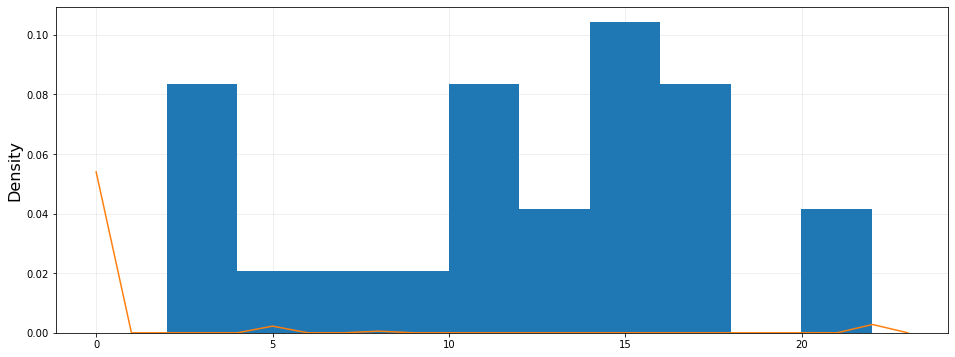

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
xbars = df['x']
# df.plot(x = 'x', y = 'y', kind = "hist" density = true)
ax.hist(x = df['x'], density = True, bins = 10)
ax.grid(alpha=0.25)
ax.set_axisbelow(True)
ax.set_ylabel("Density", fontsize=16)
# df['x']
ax.plot(stats.norm.pdf(df['x']))


**Part B**:

Things may not look perfectly normal in part A... but let's perform the tests that require normality anyways:

For Part B only, assume each observation is independent and identically distributed as a normal random variable.

- Create a 95% confidence interval for the mean of a galaxy's distance from Earth in Mega parsecs.
- Create a 95% confidence interval for the standard deviation of a galaxy's distance from Earth in Mega parsecs.

In [50]:
n=len(df)
xbar=np.sum(df['x'])/n
svar=np.sum((xi-xbar)**2/(n-1) for xi in df['x'])
sd=np.sqrt(svar)
print("Mean 95% CI: ",stats.norm.interval(.95, loc=xbar, scale=sd/np.sqrt(n)), "SD 95% CI: ",
stats.norm.interval(.95, loc=sd, scale=sd/np.sqrt(n)))

Mean 95% CI:  (9.728282115953515, 14.380884550713152) SD 95% CI:  (3.4883474348841643, 8.140949869643801)


<ipython-input-50-50d71b547c77>:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  svar=np.sum((xi-xbar)**2/(n-1) for xi in df['x'])


**Part C**:

For part C only, assume each observation is independent and identically distributed but is **not** normally distributed.  Instead, use bootstrapping to:

- Create a 95% confidence interval for the mean of a galaxy's distance from Earth in Mega parsecs.
- Create a 95% confidence interval for the standard deviation of a galaxy's distance from Earth in Mega parsecs.
- Create a 95% confidence interval for the interquartile range (both lower and upper quartiles) of a galaxy's distance from Earth in Mega parsecs.

Use 10,000 bootstrapped samples to make the statistics above.

In [69]:
# Adapted from notebook 18, modified for this problem

def bootstrapped_mean(sample, num_boots=10000):

    # np.mean of df['x']
    meanci = np.array([np.mean(np.random.choice(sample, replace=True, size=len(sample))) for ii in range(num_boots)])
    # 95% -> 2.5% --- 97.5%
    L, U = np.percentile(meanci, 2.5), np.percentile(meanci, 97.5)
    # Place lower/upper into array and return
    CI = np.array([L, U])
    return CI 
    
def bootstrapped_var(sample, num_boots=10000):

    # np.std of df['x']
    sdci = np.array([np.std(np.random.choice(sample, replace=True, size=len(sample))) for ii in range(num_boots)])
    L, U = np.percentile(sdci, 2.5), np.percentile(sdci, 97.5)
    CI = np.array([L, U])
    
    return CI 
    


In [68]:
print(bootstrapped_mean(df['x']),bootstrapped_var(df['x']))

[ 9.69075    14.30045833] [4.21508947 6.71738595]


[Back to top](#top)

<a id='p2'></a>

## (25 pts) Problem 2 (Theory): Practice with SLR and Inference


In this problem we will explore the `mortality.csv` data introduced in notebook21.  In that notebook we found some linear regression coefficients and did a related hypothesis test.  In this exercise we will "finish" analysis on that data set by exploring and visualizing the underlying assumptions, and performing some more nuanced inference.

This data set has two variables:

- `Rate`; the annual mortality rate (as a percentage) over the years 1958–1964 of 61 towns in England and Wales.
- `Calc`; the recorded calcium concentration in the drinking water supply for those towns, in parts-per-million

In [72]:
# Path to the data - select the path that works for you 
file_path = '../data/mortality.csv'

# Load the data into a DataFrame 
df = pd.read_csv(file_path)
print(len(df))
df.head(10)

61


,Rate,Calc
0,1.247,105
1,1.392,73
2,1.260,21
3,1.259,133
4,1.236,101
5,1.627,53
6,1.581,14
7,1.609,18
8,1.755,12
9,1.723,44


**A)** Perform a simple linear regression model using the `OLS` method from `statsmodels`.  Print the resulting `summary` table and then as a print statement or in a markdown cell typeset the actual line of best fit, using the coefficients from your fit.  (See: `.params`.)

In [79]:
# In notebook example, Calc is treated as x, Rate is treated as y
print((sm.OLS(df['Rate'],df['Calc']).fit()).summary())

                                 OLS Regression Results                                
Dep. Variable:                   Rate   R-squared (uncentered):                   0.526
Model:                            OLS   Adj. R-squared (uncentered):              0.518
Method:                 Least Squares   F-statistic:                              66.56
Date:                Mon, 18 Apr 2022   Prob (F-statistic):                    2.63e-11
Time:                        01:26:43   Log-Likelihood:                         -89.950
No. Observations:                  61   AIC:                                      181.9
Df Residuals:                      60   BIC:                                      184.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------


#### Part B: Visualize.  Make a figure contianing 3 side-by-side plots.  Lefthand plot: scatter plot of the data set with overlay the line of best least-squares fit.  Middle plot: histogram of *residuals* of best least-squares fit are the y-axis.  Righthand plot: scatter plot where the original x-values are the x-axis and the *residuals* are the y-axis.

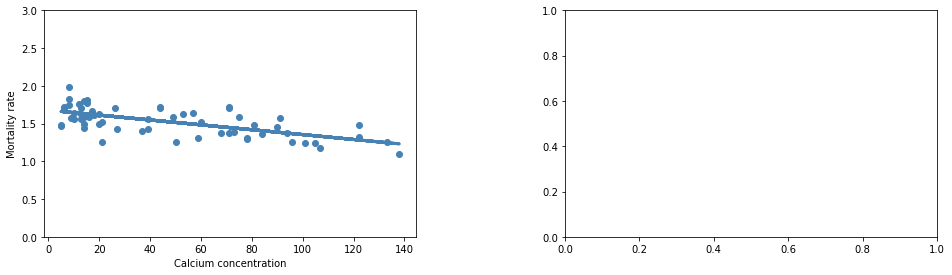

In [91]:
fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax1 = fig.add_subplot(221)
ax1.scatter(df["Calc"], df["Rate"], color="steelblue")
ax1.set_ylim([0,3])
ax1.set_xlabel("Calcium concentration")
ax1.set_ylabel("Mortality rate")
# Line of best least square fit
bhat, ahat, rval, pval, stderr = stats.linregress(df['Calc'], df['Rate'])
ax1.plot(df['Calc'], ahat + bhat*df['Calc'], color="steelblue", lw=3)

ax2 = fig.add_subplot(222)


**Part C**: For each of the 4 major assumptions of the simple linear regression model, use your plots in part B to decide whether or not the data set meets those assumptions.

**Solution:**
- Restate and discuss (briefly) assumption 1 here
- Restate and discuss (briefly) assumption 2 here
- Restate and discuss (briefly) assumption 3 here
- Restate and discuss (briefly) assumption 4 here


**D**: In the rest of this problem we will draw specific conclusions from our analysis and linear model.  For each prompt, you should provide both a numerical answer and a full sentence explaining the conclusion.

**D1)**:  How much of the variance in the mortality rates could be explained by the calcium in the drinking water?  Does this seem like a high value?

**D2)**:  A skeptic insists that "there's no way water quality is actually affecting death rates."  You decide that your linear model demonstrates other wise.  State the null and alternative hypotheses, and use the values on your `summary` table at a significance of $\alpha=0.01$ to argue against this skeptic.

**D3)**:  The government decides they believe your analysis in **D2)** that `Calc` values matter, but augmenting the drinking supply with Calcium is costly.  They insist that they don't actually want to take any actions unless you can demonstrate that the effects of `Calc` concentration on mortality `Rate` are *large enough*.  In particular, they will implement a calcification campaign if and only if you can demonstrate that at a significance of $\alpha=0.01$ one part-per-million of `Calcium` decreases mortality rate by more than 0.0025 percentage.

State the null and alternative hypotheses, and use the values on your summary table to recommend an action to the government (you may want to check out `.bse` of your linear model)

**D4)**:  The town of Manchester and their football clubs are loathsome.  While the town wasn't originally tested, we are told that the calcium concentration in their drinking water is exactly 100 ppm.

What is the 95% **prediction** band for the mortality rate in Manchester?  In other words, given our linear model, what is the interval that we think should contain the actual mortality rate for Manchester?

What is the 95% **confidence** band for the mortality rate in Manchester?  In other words, what is the interval that we think should contain the **mean** mortality rate for any town with a Calcium concentration of 100 ppm?

*Hint:* These are the things computed in the `SLR Confidence and Prediction.ipynb`... make sure to include an intercept!

[Back to top](#top)
